## Preamble

Run these if notebook is in a new environment, otherwise just skip to `Import modules`

1. partisipp + konjugert verb: kan vi se mønstre i hva som kan stå som konjugert verb?  Jeg ha noen vage resultater - at det er større variasjon i hva som opptrer i det konjugert elementet i oversatt tekst - men jeg er ikke sikker.

1. Har vi eksempler fra NB-korpusene på bli+partisipp, hvor partisippet ikke er et av de vanlige posisjonsverbene (jf ble lesende/ble drikkende  vs ble sittende og lese/drikke) - altså hele variasjonsbredden i denne strukturen.
1. - oppfølgingsspørsmål etter b) er det forskjell i variasjonsbredden i original vs oversatt norsk?

1. kunne tenkt meg å se hvilke partisipper som opptrer med 'fant ham/henne/dem + partisipp - tilsvarende 'så ham/henne/dem/deg + partisipp) (objektspredikativer) (Typisk: jeg fant ham + posisjonsverb (fant ham liggende/stående/sittende i grøfta - men ikke typisk:  fant ham gråtende/drikkende/etc

1. Partisipper i begynnelsen av setninger (frie predikativer):  Sittende med hodet i hendene fikk han endelig en ide....../Sittende på trappen med boken foran seg lignet han en filosof  - hvilke andre verb opptrer i slike partisipper?


#### Boot cell

Skip if `module_update.py` is in same folder as notebook, next cell downloads this file which in turn will download other files.

In [1]:
import dhlab.module_update as mu

In [2]:
from dhlab.module_update import update, css

In [3]:
css()

In [4]:
update('collocations')

Updated file `D:\Documents\GitHub\Oversettelse\collocations.py`

In [5]:
from collocations import dist_coll_urn

# Import modules

Aktiver cellen nedenfor for å få alt til å virke.

In [6]:
import dhlab.nbtext as nb
from IPython.display import HTML
import requests
from bs4 import BeautifulSoup
import pandas as pd

def mods_digibok(urn, kind='marcxml'):
    """find information about serial number urn (or full urn) for books using NB API. 
    Parameter 'kind' is one of mods, marcxml or dublincore """
    
    if not str(urn).startswith('URN'):
        urnstr = "URN:NBN:no-nb_digibok_{urn}".format(urn=urn)
    r = requests.get("https://api.nb.no:443/catalog/v1/metadata/{ident}/{kind}".format(ident=urnstr, kind=kind))
    return r.text

def translator(urn):
    """Finds the translator for a book"""
    item = BeautifulSoup(mods_digibok(urn, kind='mods'), 'lxml')
    trans = []
    navn = item.find_all('name', {'type':'personal'})
    for i in navn:

        try:
            if i.roleterm.text == 'trl':
                trans.append(i.namepart.text)
        except:
            'nn'
    return ';'.join(trans)
    

In [7]:
def categorize(list_of_words):
    proprium = [x for x in list_of_words if x[0].upper() == x[0]]
    other = [x for x in list_of_words if not x in proprium]

    return {'propr':proprium,
           'other': other }

def select_form(w):
    fs = [x.split()[0] for x in nb.word_form(w)]
    if 'prep' in fs:
        res = 'prep'
    if 'verb' in fs:
        res = 'verb'
    elif 'subst' in fs:
        res = 'subst'
    elif len(fs) > 0:
        res = fs[0]
    else:
        res = 'unknown'
    return res

def sort_word_forms(words):
    res = {select_form(w):w for w in words}
    return res

def mdprint(forskjell, cutoff=5):
    categories = categorize(forskjell[forskjell > cutoff].dropna().index)
    forms = {w:select_form(w) for w in categories['other']}
    Grouping = {cat:[word for word in forms if forms[word] == cat] for cat in forms.values()}
    navn = "## Egennavn \n"
    navn += ', '.join(categories['propr'])
    pos = ""
    for cat in Grouping:
        pos += "## " + cat + "\n"
        pos += ', '.join(Grouping[cat]) + "\n"
    mu.printmd(navn)
    mu.printmd(pos)
    return

def velg_form(word):
    former = list({x.split()[0] for x in nb.word_form(word)})
    if 'prep' in former:
        res = 'prep'
    elif 'det' in former:
        res = 'det'
    elif 'pron' in former:
        res = 'pron'
    elif 'verb' in former:
        res = 'verb'
    elif 'subst' in former:
        res = 'subst'
    elif 'adj' in former:
        res = 'adj'
    else:
        try:
            res = former[0]
        except:
            res = 'ukjent'
    return res

def klassifikasjon(df, num = 60, column = 0, up=False):
    gruppering = list(map(lambda w: (w, velg_form(w)), df.sort_values(by=column, ascending=up).head(num).index))
    grupper = dict(gruppering)
    grupperinger = {cat:[w for w in grupper if grupper[w] == cat] for cat in grupper.values()}
    return nb.frame(grupperinger).transpose().fillna('')

In [8]:
def wordbags(words, urns):
    url = 'https://api.nb.no/ngram/wordbags'
    if isinstance(words, str):
        return
    if isinstance(words, list):
        words = {w:[w] for w in words}
    r = requests.post(url, json={'wordbags':words, 'urns':urns})
    return r.json()

In [9]:
def word_frequencies(words):
    url = 'https://api.nb.no/ngram/word_frequencies'
    if isinstance(words, str):
        words = words.split()
    r = requests.post(url, json={'words':words})
    return r.json()

In [10]:
from random import sample

import inspect
def urn_concordance(urns = None, word = None, size = 5, before = None, after = None, html=False):
    """ Find a concordance within a corpus as list of URNs. This is a wrapper for get_urnkonk """
    
    # exit if list of urns is empty
    if urns is None or word is None:
        return []
    
    # The URNs may be presented in different ways. 
    urns = nb.pure_urn(urns)
    
    # find values and feed everything to get_urnkonk
    frame = inspect.currentframe()
    args, _, _, values = inspect.getargvalues(frame)
    query = {i:values[i] for i in args if values[i] != None and i != 'word'}
    return nb.get_urnkonk(word, query, html=html)

In [11]:
nb.word_paradigm('spisende')

[['adj', ['spisende', 'spist', 'spiste']],
 ['verb', ['spis', 'spise', 'spiser', 'spises', 'spist', 'spiste']]]

## Build corpus

A corpus definition is a set of URNs. Those can be obtained in various ways and stored as text or in MS-Word file.


### Define using metadata 

Lag korpus manuelt, fra excel eller andre kilder. Bare lim inn definisjonen mellom de triple """ """ under

In [16]:
korpus = pd.read_csv('korpus_file_1980.csv', index_col = 0)

In [17]:
korpus_nob = pd.read_csv('korpus_file_nob.csv', index_col = 0)

# Henter bøkene med ord

Her defineres korpuset som en liste over bøker, med informasjon om oversettere. Er korpuset stort (flere hundre) vil det ta noen minutter å hente alle oversetterne, så det kan være lurt å kutte ned størrelsen litt. Inntil vi får på plass en rask måte å gjøre det på, får det her duge. Det er bare å smøre seg med tålmodighet.

## Search corpus for concordances

In [18]:
from random import sample

In [19]:
nb.urn_concordance(word='leende', urns= sample(nb.pure_urn(korpus), 50))

# Definer teksten

Lager mindre versjon av TEXT og TEXT_NOB for Github

In [21]:
TEXT = pd.read_csv('korpus_file_f5_1980.csv', index_col = 0)
TEXT_NOB = pd.read_csv('korpus_file_nob_f5_1980.csv', index_col = 0)

#### convertet to md
import pandas as pd
with open ('korpus_file.csv','r', encoding="utf-8") as f:
    text = pd.read_csv(f)

In [22]:
TEXT.sort_values(by=TEXT.columns[0], ascending=False)[:10]

,2013031206018,2013040507021,2011012105050,2015082548139,2012071806015,2012022908075,2016030907022,2012062806124,2009092900105,2013012907209,...,2015072108291,2012012008059,2011110208183,2010101208095,2011022320087,2014032406004,2015102308102,2016062748040,2014103008108,2013060708127
",",1717.0,3488.0,556.0,4515.0,46.0,3314.0,2644.0,6094.0,1519.0,3022.0,...,4557.0,77.0,12.0,90.0,1744.0,3826.0,6422.0,3996.0,3368.0,4342.0
.,1713.0,9025.0,914.0,8095.0,61.0,5714.0,3384.0,7673.0,2577.0,4247.0,...,4059.0,241.0,30.0,247.0,2640.0,4929.0,7894.0,5459.0,2423.0,5566.0
«,1000.0,24.0,655.0,200.0,1.0,1325.0,73.0,1745.0,1402.0,7.0,...,1277.0,NaN,2.0,46.0,4.0,122.0,184.0,2124.0,55.0,1740.0
»,971.0,23.0,634.0,183.0,6.0,1380.0,72.0,1720.0,1373.0,7.0,...,1262.0,NaN,1.0,56.0,21.0,119.0,170.0,2089.0,54.0,1718.0
det,829.0,2265.0,242.0,1925.0,9.0,1552.0,1237.0,2531.0,530.0,838.0,...,1518.0,33.0,2.0,40.0,615.0,1390.0,1531.0,1908.0,742.0,1957.0
og,788.0,2863.0,283.0,2822.0,16.0,1646.0,1709.0,4119.0,747.0,1633.0,...,2508.0,47.0,3.0,73.0,690.0,2268.0,5462.0,3180.0,1436.0,2435.0
er,584.0,1181.0,254.0,1319.0,7.0,433.0,518.0,1510.0,399.0,385.0,...,759.0,12.0,4.0,5.0,419.0,529.0,738.0,1056.0,441.0,1094.0
å,507.0,1718.0,152.0,1003.0,2.0,1162.0,844.0,1571.0,624.0,717.0,...,992.0,17.0,NaN,28.0,415.0,1252.0,1684.0,1222.0,870.0,1464.0
som,432.0,1140.0,82.0,1131.0,4.0,1234.0,537.0,1674.0,277.0,678.0,...,1028.0,16.0,2.0,28.0,281.0,1094.0,2150.0,1189.0,967.0,916.0
en,415.0,1351.0,155.0,1484.0,4.0,1174.0,715.0,2014.0,320.0,835.0,...,1168.0,NaN,4.0,31.0,456.0,1330.0,1609.0,1205.0,787.0,1144.0


### Starter med listen over mulige partisipper

In [23]:
TEXT.index = TEXT.index.map(str)

In [24]:
poss_part = list ({x for x in TEXT.index if x.endswith('ende')})

In [25]:
TEXT.index

Index([',', '.', '«', '»', 'det', 'og', 'er', 'å', 'som', 'en',
       ...
       '„', '•', '€', '™', '□', '►', '▼', '★', '♦', '✓'],
      dtype='object', length=73246)

### Henter ut de 100 mest frekvente

In [26]:
N = 200
test_words = list(TEXT.loc[TEXT.index.str.contains(".*ende")].sum(axis=1).sort_values(ascending=False)[:N].index)

In [27]:
variants = dict()
for w in test_words:
    variants[w] = nb.word_paradigm(w)

In [28]:
forms = dict()
for w in test_words:
    forms[w] = nb.word_form(w)

In [29]:
nb.frame(variants)

,0,1,2,3
hendene,"[subs, [henda, hende, hendene, hender, hendet,...",None,None,None
stående,"[adj, [stående, stått, ståtte]]","[verb, [sto, stod, stå, ståes, står, stås, stå...",None,None
hender,"[adj, [hendende, hendt, hendte]]","[subs, [henda, hende, hendene, hender, hendet,...","[verb, [hend, hende, hender, hendes, hendt, he...",None
endelig,"[adj, [endelig, endelige, endeligere, endeligs...",None,None,None
enden,"[subs, [ende, enden, endene, ender]]",None,None,None
sende,"[adj, [sendende, sendt, sendte]]","[verb, [send, sende, sender, sendes, sendt, se...",None,None
rasende,"[adj, [rasa, rasende, rast, raste]]","[adv, [rasende]]","[verb, [ras, rasa, rase, raser, rases, rast, r...",None
sittende,"[adj, [sitne, sitten, sittende, sittet]]","[verb, [satt, sitt, sitte, sitter, sittes, sit...",None,None
levende,"[adj, [levd, levde, levede, levende, levet, le...","[verb, [lev, levd, levde, leve, lever, leves, ...",None,None
hende,"[adj, [hendende, hendt, hendte, hende]]","[subs, [henda, hende, hendene, hender, hendet]]","[verb, [hend, hende, hender, hendes, hendt, he...",None


## Velg former

Plukk ut partisippformene, dersom formen opptrer både som adjektiv og som verb, ellers ut. Nedenfor plukkes ut de alternative verbformene som kan sammenlignes med partisippen.

Her benyttes en enkelt heuristikk. Partisippformen må være oppført både som et adjektiv og et verb, i tillegg må ikke formen selv være blandt verbene.

In [30]:
participles = dict()
for w in variants:
    # finn POS for alle variantene
    kinds = [x[0] for x in variants[w]]
    
    # sjekk at både adj og verb er blant dem
    if 'adj' and 'verb' in kinds:
        
        # Ta ut de som har formen blant verbene (partisippet er ikke verd i NO)
        F = [k[1] for k in variants[w] if k[0] == 'verb' and not w in k[1] ]
        if F != []:
            participles[w] = F

## Se på resultatet

In [31]:
participles

{'stående': [['sto', 'stod', 'stå', 'ståes', 'står', 'stås', 'stått']],
 'rasende': [['ras', 'rasa', 'rase', 'raser', 'rases', 'rast', 'raste']],
 'sittende': [['satt', 'sitt', 'sitte', 'sitter', 'sittes', 'sittet']],
 'levende': [['lev', 'levd', 'levde', 'leve', 'lever', 'leves', 'levet']],
 'liggende': [['ligg', 'ligge', 'ligger', 'ligges', 'ligget', 'lå', 'låg']],
 'strålende': [['strål', 'stråle', 'stråler', 'stråles', 'strålt', 'strålte']],
 'skinnende': [['skein',
   'skinn',
   'skinne',
   'skinner',
   'skinnes',
   'skint',
   'skinte']],
 'smilende': [['smil', 'smile', 'smiler', 'smiles', 'smilt', 'smilte']],
 'skjelvende': [['skalv',
   'skjelv',
   'skjelve',
   'skjelver',
   'skjelves',
   'skjelvet']],
 'spennende': [['spenn', 'spenne', 'spenner', 'spennes', 'spent', 'spente']],
 'utseende': [['utse', 'utsees', 'utser', 'utses', 'utsett', 'utså', 'utsåg']],
 'hengende': [['heng',
   'henge',
   'henger',
   'henges',
   'hengt',
   'hengte',
   'hang']],
 'gående': [['g

Nå lager vi en ny statistikk der alle ordene telles opp fra datarammen for sammenligning

In [32]:
counts = dict()
for w in participles:
    counts[w] = max(1, TEXT.loc[list(set(participles[w][0]) & set(TEXT.index))].sum(axis=1).sum())

In [33]:
counts_nob = dict()
for w in participles:
    counts_nob[w] = max(1, TEXT_NOB.loc[list(set(participles[w][0]) & set(TEXT_NOB.index))].sum(axis=1).sum())

In [34]:
counts_nob

{'stående': 28259.0,
 'rasende': 735.0,
 'sittende': 29748.0,
 'levende': 5685.0,
 'liggende': 17147.0,
 'strålende': 434.0,
 'skinnende': 1284.0,
 'smilende': 6607.0,
 'skjelvende': 1218.0,
 'spennende': 1271.0,
 'utseende': 14.0,
 'hengende': 4227.0,
 'gående': 53923.0,
 'truende': 2111.0,
 'skremmende': 1270.0,
 'løpende': 4915.0,
 'passende': 3086.0,
 'lignende': 1395.0,
 'beroligende': 193.0,
 'brennende': 2171.0,
 'spørrende': 11392.0,
 'vedkommende': 76.0,
 'flytende': 996.0,
 'tiltrekkende': 146.0,
 'triumferende': 63.0,
 'glitrende': 298.0,
 'følgende': 7106.0,
 'overraskende': 587.0,
 'nølende': 600.0,
 'imponerende': 195.0,
 'sjarmerende': 14.0,
 'lysende': 8859.0,
 'utelukkende': 126.0,
 'oppmuntrende': 121.0,
 'glødende': 380.0,
 'døende': 6357.0,
 'forbausende': 638.0,
 'avgjørende': 538.0,
 'forbløffende': 131.0,
 'besøkende': 1701.0,
 'overbevisende': 556.0,
 'overveldende': 153.0,
 'skingrende': 52.0,
 'glimrende': 18.0,
 'overlevende': 449.0,
 'omgående': 147.0,
 'utf

In [35]:
counts

{'stående': 31682.0,
 'rasende': 1237.0,
 'sittende': 34494.0,
 'levende': 5363.0,
 'liggende': 18761.0,
 'strålende': 576.0,
 'skinnende': 1607.0,
 'smilende': 12655.0,
 'skjelvende': 2257.0,
 'spennende': 1320.0,
 'utseende': 36.0,
 'hengende': 4935.0,
 'gående': 81579.0,
 'truende': 1365.0,
 'skremmende': 2021.0,
 'løpende': 9133.0,
 'passende': 4864.0,
 'lignende': 1768.0,
 'beroligende': 466.0,
 'brennende': 2348.0,
 'spørrende': 22886.0,
 'vedkommende': 86.0,
 'flytende': 939.0,
 'tiltrekkende': 378.0,
 'triumferende': 69.0,
 'glitrende': 439.0,
 'følgende': 10603.0,
 'overraskende': 1621.0,
 'nølende': 1693.0,
 'imponerende': 529.0,
 'sjarmerende': 49.0,
 'lysende': 10810.0,
 'utelukkende': 188.0,
 'oppmuntrende': 410.0,
 'glødende': 606.0,
 'døende': 8881.0,
 'forbausende': 1854.0,
 'avgjørende': 1150.0,
 'forbløffende': 684.0,
 'besøkende': 3182.0,
 'overbevisende': 1837.0,
 'overveldende': 331.0,
 'skingrende': 69.0,
 'glimrende': 13.0,
 'overlevende': 880.0,
 'omgående': 245

# Legg til opptellinger for partisippene

In [36]:
count_frame = {x: {'verb_paradigm': counts[x], 'participle': TEXT.loc[x].sum()} for x in counts}

In [37]:
count_frame_nob = {x: {'verb_paradigm': counts_nob[x], 'participle': TEXT_NOB.loc[x].sum()} for x in counts_nob}

In [38]:
count_frame

{'stående': {'verb_paradigm': 31682.0, 'participle': 3063.0},
 'rasende': {'verb_paradigm': 1237.0, 'participle': 1973.0},
 'sittende': {'verb_paradigm': 34494.0, 'participle': 1823.0},
 'levende': {'verb_paradigm': 5363.0, 'participle': 1599.0},
 'liggende': {'verb_paradigm': 18761.0, 'participle': 1259.0},
 'strålende': {'verb_paradigm': 576.0, 'participle': 1080.0},
 'skinnende': {'verb_paradigm': 1607.0, 'participle': 839.0},
 'smilende': {'verb_paradigm': 12655.0, 'participle': 809.0},
 'skjelvende': {'verb_paradigm': 2257.0, 'participle': 804.0},
 'spennende': {'verb_paradigm': 1320.0, 'participle': 799.0},
 'utseende': {'verb_paradigm': 36.0, 'participle': 751.0},
 'hengende': {'verb_paradigm': 4935.0, 'participle': 707.0},
 'gående': {'verb_paradigm': 81579.0, 'participle': 693.0},
 'truende': {'verb_paradigm': 1365.0, 'participle': 608.0},
 'skremmende': {'verb_paradigm': 2021.0, 'participle': 607.0},
 'løpende': {'verb_paradigm': 9133.0, 'participle': 600.0},
 'passende': {'v

In [39]:
COUNTS = nb.frame(count_frame)

In [40]:
COUNTS.head()

,verb_paradigm,participle
advarende,866.0,239.0
anerkjennende,139.0,143.0
angående,678.0,241.0
anklagende,508.0,128.0
anstrengende,645.0,147.0


In [41]:
COUNTS_NOB = nb.frame(count_frame_nob)

In [42]:
COUNTS_NOB.head()

,verb_paradigm,participle
advarende,270.0,95.0
anerkjennende,181.0,86.0
angående,461.0,88.0
anklagende,258.0,57.0
anstrengende,267.0,85.0


In [43]:
TOT = nb.totals(50000)

In [44]:
TOT = nb.frame(TOT)

Legg til en kolonne med ratioen melllom de to første. 

In [45]:
COUNTS['ratio'] = COUNTS['participle']/(COUNTS['participle']+COUNTS['verb_paradigm'])

In [46]:
COUNTS_NOB['ratio'] = COUNTS_NOB['participle']/(COUNTS_NOB['participle']+COUNTS_NOB['verb_paradigm'])

# Sortér på ratio

Her ser vi klart at det kanskje ikke er ekte partisipper på topp, mer typiske ord i partisippform.

De mest interessante ordene (tror jeg) er på bunnen her, som 'smilende', 'løpende', 'liggende', 'spørrende'. Og den ratioen kan sammenlignes med norsk sett.

In [47]:
COUNTS.sort_values(by='ratio', ascending=False)

,verb_paradigm,participle,ratio
fremtredende,1.0,127.0,0.992188
glimrende,13.0,288.0,0.956811
gjennomtrengende,9.0,195.0,0.955882
utseende,36.0,751.0,0.954257
sjarmerende,49.0,375.0,0.884434
misbilligende,19.0,144.0,0.883436
triumferende,69.0,398.0,0.852248
vedkommende,86.0,441.0,0.836812
skingrende,69.0,289.0,0.807263
fortryllende,35.0,141.0,0.801136


In [48]:
COUNTS_NOB.sort_values(by='ratio', ascending=False)

,verb_paradigm,participle,ratio
misbilligende,1.0,36.0,0.972973
utseende,14.0,254.0,0.947761
glimrende,18.0,106.0,0.854839
sjarmerende,14.0,81.0,0.852632
vedkommende,76.0,275.0,0.783476
foruroligende,18.0,63.0,0.777778
nedlatende,22.0,75.0,0.773196
skingrende,52.0,159.0,0.753555
fortryllende,19.0,58.0,0.753247
tilsvarende,67.0,200.0,0.749064


# Sammenligner ratio for oversatt mot NOB

In [49]:
COMP = COUNTS['ratio']/COUNTS_NOB['ratio']

In [54]:
HTML(nb.frame(COMP.sort_values(ascending=False)).to_html())

,ratio
fremstående,3.970329
verkende,3.559227
bydende,2.464312
overlevende,2.458442
besøkende,2.071236
flytende,1.909213
tiltalende,1.886774
gapende,1.861569
truende,1.857032
lovende,1.832177


In [51]:
COUNTS['participle'].loc['verkende']

131.0

In [52]:
COUNTS_NOB['participle'].loc['verkende']

68.0

In [53]:
all_participles = list(set(COUNTS.participle.index) | set(COUNTS_NOB.participle.index))

# Make concordances of all from both corpora

## Aggregates of texts

In [55]:
TEXT_NOB.sum(axis=1).sum()

15195470.0

In [56]:
TEXT.sum(axis=1).sum()

22656570.0

In [60]:
punkt = nb.unigram('.', ddk="8%", trans='eng', period=(1945, 2000))

In [70]:
like = nb.unigram('likestilling', ddk="8%", trans='eng', period = (1945, 2000))

In [82]:
def relfrekvens(word, **kwarg):
    punkt = nb.unigram('.', **kwarg)
    wd = nb.unigram(word, **kwarg)
    return nb.frame(wd/punkt, word)

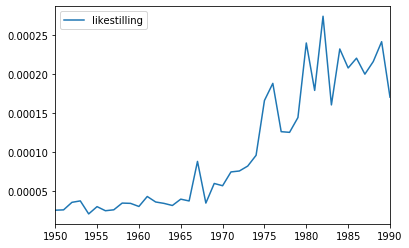

In [83]:
relfrekvens('likestilling',media='bok', period=(1950, 1990)).plot()

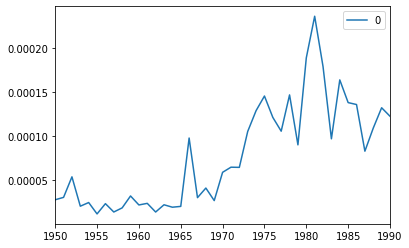

In [79]:
relfrekvens('abort',media='bok', period=(1950, 1990)).plot()

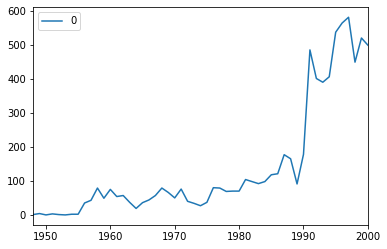

In [66]:
nb.unigram('verkende', ddk="8%", trans='eng', period=(1945, 2000)).plot()

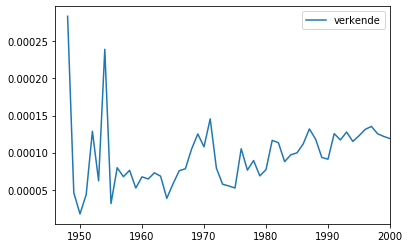

In [90]:
relfrekvens('verkende',ddk="8%", trans='eng', period=(1945, 2000)).plot()

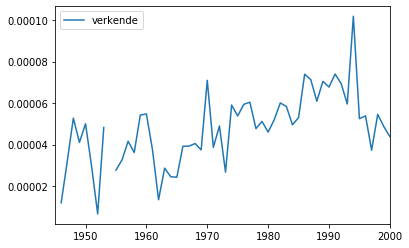

In [91]:
relfrekvens('verkende', ddk="8%", trans='', period=(1945, 2000)).plot()

In [92]:
counts_tot = dict()
for w in participles:
    counts_tot[w] = max(1, TOT.loc[list(set(participles[w][0]) & set(TOT.index))].sum(axis=1).sum())

In [95]:
counts_tot

{'stående': 19437983,
 'rasende': 635995,
 'sittende': 19514023,
 'levende': 5312408,
 'liggende': 14864068,
 'strålende': 323529,
 'skinnende': 864480,
 'smilende': 3740043,
 'skjelvende': 683719,
 'spennende': 751509,
 'utseende': 73206,
 'hengende': 2623103,
 'gående': 39842605,
 'truende': 2250953,
 'skremmende': 643472,
 'løpende': 4492046,
 'passende': 3018854,
 'lignende': 1124850,
 'beroligende': 161135,
 'brennende': 1559790,
 'spørrende': 7493284,
 'vedkommende': 67666,
 'flytende': 644943,
 'tiltrekkende': 202167,
 'triumferende': 1,
 'glitrende': 131025,
 'følgende': 8535735,
 'overraskende': 561859,
 'nølende': 385535,
 'imponerende': 200342,
 'sjarmerende': 1,
 'lysende': 5765415,
 'utelukkende': 329885,
 'oppmuntrende': 242364,
 'glødende': 214013,
 'døende': 4840940,
 'forbausende': 400348,
 'avgjørende': 1212211,
 'forbløffende': 123009,
 'besøkende': 1711432,
 'overbevisende': 674140,
 'overveldende': 91829,
 'skingrende': 1,
 'glimrende': 1,
 'overlevende': 539336,
 

In [96]:
count_frame_tot = {x: {'verb_paradigm': counts_tot[x], 'participle': TOT.loc[x].sum()} for x in counts_tot if x in TOT.index}

In [97]:
TOTCOUNT = nb.frame(count_frame_tot)

In [98]:
TOTCOUNT

,verb_paradigm,participle
advarende,336853,66111
anerkjennende,361350,46021
angående,572794,267385
anklagende,289970,36067
anstrengende,247621,72006
avgjørende,1212211,1008752
bebreidende,122541,42515
bedende,4314613,62088
beroligende,161135,171112
beskyttende,935404,101438


In [99]:
TOTCOUNT['ratio'] = TOTCOUNT['participle']/(TOTCOUNT['participle']+TOTCOUNT['verb_paradigm'])

In [100]:
TOTCOUNT.sort_values(by='ratio', ascending=False)

,verb_paradigm,participle,ratio
glimrende,1,185539,0.999995
sjarmerende,1,103095,0.999990
triumferende,1,96177,0.999990
skingrende,1,70651,0.999986
gjennomtrengende,1,53225,0.999981
nedlatende,1,51633,0.999981
foruroligende,1,48308,0.999979
fortryllende,1,40939,0.999976
misbilligende,1,27242,0.999963
skurrende,1,22798,0.999956


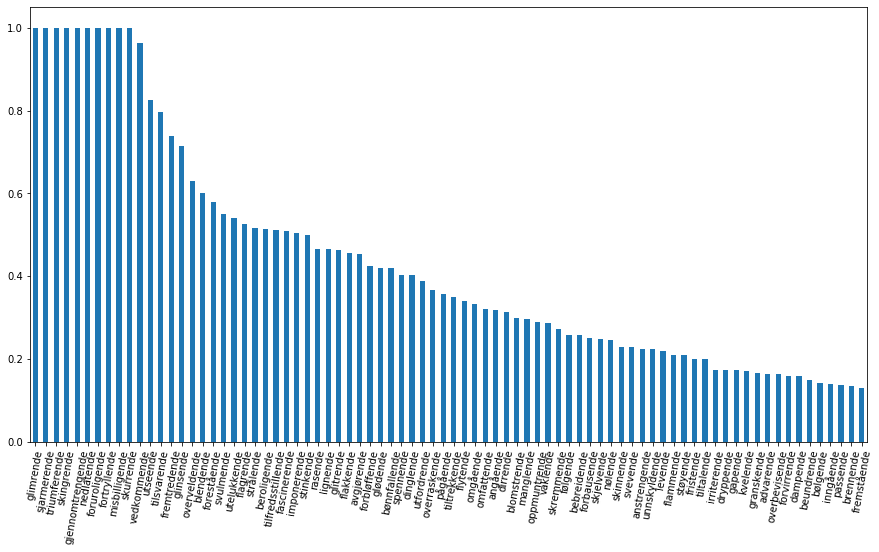

In [101]:
TOTCOUNT.sort_values(by='ratio', ascending=False)[:80]['ratio'].plot(kind='bar', figsize=(15, 8), rot=80)

In [86]:
relaterte = dict()
for w in TOTCOUNT.sort_values(by='ratio', ascending=False)[:50].index:
    try:
        relaterte[w] = nb.relaterte_ord(w)
    except:
        print('problem: ', w)

problem:  triumferende
problem:  skingrende
problem:  gjennomtrengende
problem:  nedlatende
problem:  misbilligende
problem:  skurrende
problem:  vedkommende
problem:  glinsende
problem:  overveldende
problem:  utelukkende
problem:  glitrende
problem:  flakkende
problem:  forbløffende
problem:  bønnfallende
problem:  dinglende
problem:  flytende
problem:  omgående
problem:  angående
problem:  dirrende


In [87]:
import dhlab.graph_networkx_louvain as gnl

In [88]:
for participle in relaterte:
    mu.printmd("## {p} \n {words}\n".format(p=participle, words = ", ".join(relaterte[participle])))

## glimrende 
 snø, sol, sne, glimrende, kuldegrader, vind, regn, fint, kulde, slaps, is, sludd, frost, skiføre, isdekke, glatt, vindstille, tåke, fleksibel, nydelig


## sjarmerende 
 sjarmerende, morsom, hyggelig, underholdende, blid, utadvendt, innholdsrik, lærerik, dyktig, grei, kjekk, tiltalende, koselig, vittig, interessant, søt, spennende, inspirerende, omgjengelig, hjelpsom


## foruroligende 
 kraft, energi, vilje, styrke, fart, spenst, foruroligende, tyngde, fylde, farlig, uoversiktlig, vanskelig, uforutsigbar


## fortryllende 
 fargerik, poetisk, dramatisk, humoristisk, vakker, fortryllende, festlig, fantasifull, flott, frodig, spennende, variert, mangfoldig, morsom, vittig, vakkert, varm, musikalsk, burlesk, realistisk


## utseende 
 utseende, kvalitet, karakter, innhold, stil, størrelse, personlighet, smak, farge, sjarm, form, konsistens, omfang, soliditet, særpreg, væremåte, egenart, design, atmosfære, sunnhet


## tilsvarende 
 erfaring, kunnskap, praksis, kunnskaper, innsikt, rutine, utdannelse, kvalifikasjoner, kompetanse, relevant, fortrinnsvis, minimum, helst, allsidig, solid, tilsvarende, storhusholdning, servicehandel, ledererfaring, bakgrunn


## blendende 
 rent, blendende, tørt, hvitt, pent, blankt, ryddig, friskt, fint, vakkert, klart, velspilte, gammel, ny, spennende, reflekser


## forestående 
 pågående, frekk, aggressive, uredd, aktiv, utholdende, aggressiv, energisk


## svulmende 
 freidig, frodig


## flagrende 
 lys, flagrende, luft, romslig, vann, vand, pen, lyd, løst


## strålende 
 sol, strålende, vind, sne, kuldegrader, regn, fint, vindstille, varmegrader, plussgrader, himmel, varig, minusgrader, solskinn, frisk, tåke, varme, sjø, utsikt, tropevarme


## beroligende 
 amfetamin, alkohol, beroligende, avslappende, tabletter, piller, narkotiske, hasj, stimulerende, smertestillende, styrkende, ecstasy, LSD, rohypnol, hasjisj, kokain, marihuana, ecstacy, heroin, metamfetamin


## tilfredsstillende 
 forsvarlig, rasjonelt, betryggende, effektiv, tilfredsstillende, rimelig, stabil, tidsmessig, hurtig, billig, økonomisk, riktig, hensiktsmessig, fornuftig, effektivt, sikker, skånsom, målrettet, miljøvennlig, langsiktig


## fascinerende 
 utfordrende, inspirerende, spennende, interessant, lærerike, utviklende, lærerik, krevende, engasjerende, givende, lærerikt, fengslende, underholdende, fascinerende, variert, morsomt, interessante, varierende, morsom, gripende


## imponerende 
 spennende, inspirerende, skremmende, imponerende, rørende, morsomt, morsom, fengende, variert, utfordrende, engasjerende, utviklende, krevende, lærerik, lærerikt, givende, dramatisk, vakker, flott, storslått


## stinkende 
 forurensende, støyende


## rasende 
 oppgitt, skuffet, fortvilet, forbannet, lei, frustrerte, sint, opprørt, sjokkert, frustrert, irritert, sinte, rasende, provosert, deprimert, såret, desillusjonert, forbanna, føler, fortvilt


## lignende 
 konserter, messer, lignende, arrangementer, utstillinger, festivaler, seminarer, workshops, andre, turneer, teater, kunstutstillinger, plateinnspillinger, foredrag, forestillinger, teaterforestillinger, markeder, konferanser, kongresser, stands


## avgjørende 
 viktig, avgjørende, krevende, interessant, viktige, spennende, sentrale, verdifull, nødvendig, verdifullt, prinsipiell, riktig, sentral, positivt, nyttig, meningsfylt, gledelig, endelige, utfordrende, interessante


## glødende 
 røyk, aske, glødende, damp, sot, ild, støv, pliktoppfyllende, dyr, flammer, fyll, husdyr, alkohol, lukt, snus, slagg, svovel, lava, ruiner, stein


## spennende 
 spennende, utfordrende, interessant, utviklende, givende, lærerikt, krevende, lærerik, variert, inspirerende, underholdende, morsomt, interessante, engasjerende, morsom, selvstendig, hektisk, stimulerende, varierte, utfordrande


## utfordrende 
 utviklende, utfordrende, spennende, krevende, inspirerende, interessant, givende, lærerikt, stimulerende, interessante, lærerike, lærerik, Interessant, variert, selvstendig, varierende, selvstendige, varierte, allsidige, engasjerende


## overraskende 
 spennende, artig, morsom, morsomt, overraskende, interessant, hyggelig, utfordrende, underholdende, inspirerende, skremmende, lærerik, provoserende, variert, annerledes, lærerikt, givende, hektisk, nyttig, velspilt


## pågående 
 resultatorientert, utadvendt, målbevisst, selvstendig, pågående, utholdende, energisk, idérik, kreativ, offensiv, aktiv, initiativrik, uredd, ha, samarbeidsvillig, ansvarsbevisst, aggressiv, dyktig, systematisk, handlekraftig


## tiltrekkende 
 sjarmerende, tiltrekkende, spennende, skremmende, morsom, søt, underholdende, hyggelig, sexy, variert, pen, vakker, koselig, innholdsrik, tiltalende, ungdommelig, intelligent, frastøtende, sund, mystisk


## omfattende 
 omfattende, krevende, komplisert, tidkrevende, kostbar, kostbart, variert, vanskelig, kompliserte, allsidig, langvarig, ressurskrevende, grundig, utfordrende, kostbare, systematisk, detaljert, kompleks, langvarige, selvstendig


## blomstrende 
 gronne, grønne, trivelige, blomstrende, rolige, barnevennlige, landlige, rode, frodige, gule, solrike, hvite, gjestfrie, allsidige, blå, hyggelige, hjelpsomme, dyktige, brune, røde


## manglende 
 usikkerhet, manglende, mangel, uvitenhet, misforståelser, fattigdom, rot, frykt, forvirring, angst, utrygghet, fortvilelse, ensomhet, arbeidsledighet, korrupsjon, fordommer, ustabilitet, engstelse, uro, uklarhet


## oppmuntrende 
 inspirerende, stimulerende, hyggelig, spennende, overraskende, morsomt, utfordrende, trivelig, engasjerende, utviklende, krevende, faglig, lærerik, ekspansivt, uformelt, aktivt, oppmuntrende, gledelig, positivt, lærerikt


## vaklende 
 usikre, vaklende, utrygge, engstelige, frustrerte, forvirret, redde, vanskelige, urolige, nervøse, svak, sterk, splittet


## skremmende 
 skremmende, spennende, trist, tankevekkende, sjokkerende, farlig, overraskende, übehagelig, truende, fascinerende, skuffende, uvirkelig, vond, tiltrekkende, mystisk, uforutsigbare, uhyggelig, pirrende, morsom, interessant


In [89]:
TOTCOUNT

,verb_paradigm,participle,ratio
advarende,336853,66111,0.164062
anerkjennende,361350,46021,0.112971
angående,572794,267385,0.318248
anklagende,289970,36067,0.110622
anstrengende,247621,72006,0.225281
avgjørende,1212211,1008752,0.454196
bebreidende,122541,42515,0.257579
bedende,4314613,62088,0.014186
beroligende,161135,171112,0.515014
beskyttende,935404,101438,0.097834


In [90]:
COMPTOT = COUNTS['ratio']/TOTCOUNT['ratio']

In [91]:
HTML(nb.frame(COMPTOT.sort_values(ascending=False)).to_html())

,ratio
verkende,6.321689
fremstående,5.488433
anerkjennende,4.457094
bitende,4.241693
leende,3.329909
inngående,3.174104
farende,2.876035
truende,2.856607
klagende,2.630188
bydende,2.517035


Henter kollokasjonene fra fil

In [159]:
def coll_to_dict_of_df(coll_):
    coll = dict()
    for i in coll_.index:
        coll[i] = pd.DataFrame(coll_.loc[i][0])
    return coll


In [165]:
collbefore = coll_to_dict_of_df(pd.read_json("ov_before.json"))
collafter = coll_to_dict_of_df(pd.read_json("ov_after.json"))
collbefore_nob = coll_to_dict_of_df(pd.read_json("bm_before.json"))
collafter_nob = coll_to_dict_of_df(pd.read_json('bm_after.json'))

In [133]:
left_coll = pd.read_json('left_coll.json')
right_coll = pd.read_json('right_coll.json')
left_nob = pd.read_json('left_nob.json')
right_nob = pd.read_json('right_nob.json')

In [134]:
left_coll

,CLB,adj,adv,det,fork,henv,inte,konj,prep,pron,sbu,subs,symb,verb
advarende,1.0,7,1.0,8,NaN,NaN,NaN,2.0,2.0,10,NaN,8,NaN,9
anerkjennende,2.0,20,2.0,7,1.0,1.0,NaN,3.0,3.0,9,NaN,15,NaN,33
angående,NaN,10,NaN,4,NaN,NaN,NaN,NaN,2.0,4,NaN,32,NaN,17
anklagende,1.0,10,5.0,7,NaN,NaN,NaN,2.0,1.0,7,NaN,15,NaN,15
anstrengende,2.0,27,9.0,6,NaN,NaN,NaN,2.0,1.0,5,NaN,9,NaN,24
avgjørende,1.0,11,2.0,10,1.0,1.0,1.0,2.0,4.0,6,NaN,9,1.0,34
bebreidende,1.0,25,3.0,3,NaN,NaN,NaN,2.0,2.0,6,NaN,16,NaN,23
bedende,1.0,10,3.0,10,NaN,NaN,NaN,2.0,3.0,9,NaN,18,NaN,17
beroligende,1.0,12,3.0,13,1.0,1.0,NaN,2.0,3.0,12,NaN,17,NaN,21
beskyttende,1.0,9,1.0,16,2.0,1.0,NaN,2.0,4.0,8,NaN,17,NaN,9


In [166]:
nb.heatmap(collbefore_nob['smilende'].sort_values(by='weight', ascending=False)[:50])

,0,weight
Cold,0.00584795,3245.34
hemmelighetsfullt,0.00194932,1716.38
rister,0.0116959,1688.09
jomfruen,0.00194932,1613.29
forventningsfullt,0.00194932,1464.91
handelsmannen,0.00194932,1374.02
Aslaksen,0.00389864,1278.61
uanfektet,0.00194932,1242.13
Worse,0.00194932,1223.4
Richards,0.00194932,1001.04


Lag liste med fordeling av kategorier for ord

Lagre for å hente ut igjen

In [148]:
left_nob.fillna(0).style.background_gradient(axis=1)

In [150]:
left_coll.fillna(0).style.background_gradient(axis=1)

In [149]:
right_nob.fillna(0).style.background_gradient(axis=1)

In [151]:
right_coll.fillna(0).style.background_gradient(axis=1)

In [156]:
syntaks = nb.frame({'bm_før':left_nob.sum(), 'oversatt_før': left_coll.sum(), 'bm_etter':right_nob.sum(), 'oversatt_etter':right_coll.sum()})

In [161]:
syntaks.style.background_gradient(axis=1, cmap='Blues')

,CLB,adj,adv,det,fork,henv,inte,konj,prep,pron,sbu,subs,symb,verb
bm_etter,175,939,253,103,36,35,29,153,829,67,152,3344,4,1460
bm_før,184,1774,454,1169,101,76,12,275,490,889,72,1742,17,2394
oversatt_etter,195,938,294,99,41,39,30,157,924,70,175,3615,4,1528
oversatt_før,186,1888,500,1165,106,79,9,272,493,957,50,1914,12,2533


In [167]:
cbefore = pd.concat([collbefore[x] for x in collbefore], axis=1, sort=False)

In [215]:
cafter = pd.concat([collafter[x] for x in collafter], axis=1, sort=False)

In [177]:
mdprint??

In [189]:
klassifikasjon??

In [194]:
cbefore['weight'].fillna(0).mean(axis=1)

den                      7.466282
de                       5.055027
med                      3.107620
og                       1.780477
det                      2.442429
en                       5.893974
,                        0.945440
et                       6.784944
mine                     2.297322
De                       1.882372
sitt                     2.939060
sine                     1.931839
sin                      1.768515
dette                    0.708465
Med                      4.026664
slags                    4.841230
om                       0.172595
neglespreng,             0.000000
minnet                   1.532123
Den                      4.018852
hennes                   3.539373
gamlingen               14.860463
for                      0.757849
Andras                   0.000000
enn                      0.468415
eneste                   5.224934
Marguerites              0.000000
e                        0.066622
utvilsomt                3.272960
mest          

In [201]:
nb.word_form('med')

['prep normert',
 'subst nøyt appell ent ub normert',
 'subst nøyt appell fl ub normert']

In [213]:
klassifikasjon(nb.frame(cbefore[0].fillna(0).mean(axis=1)))

,det,ukjent,CLB,verb,prep,adj,pron,subst,sbu,adv
0,en,",",og,så,de,var,han,nesten,som,ganske
1,den,Den,,kom,med,mer,seg,ikke,,hvor
2,et,En,,ble,av,mest,hun,vel,,
3,det,De,,er,for,litt,jeg,,,
4,noe,Det,,bli,i,stirret,denne,,,
5,noen,,,komme,på,meget,ham,,,
6,hans,,,kommer,til,like,,,,
7,sin,,,være,henne,virket,,,,
8,to,,,sa,,smilte,,,,
9,,,,eller,,lite,,,,


In [216]:
klassifikasjon(nb.frame(cafter[0].fillna(0).mean(axis=1)))

,ukjent,prep,CLB,subst,sbu,verb,adv,det,adj
0,.,på,og,blikk,som,øyne,at,en,våt
1,",",i,,blikket,,stemme,da,,
2,:,ut,,øynene,,å,nok,,
3,?,til,,lyset,,smil,igjen,,
4,!,inn,,stemmen,,måte,,,
5,-,mot,,lyden,,var,,,
6,,med,,vinden,,ord,,,
7,,fra,,,,mann,,,
8,,for,,,,tone,,,
9,,av,,,,uttrykk,,,


In [206]:
klassifikasjon(nb.frame(cbefore['weight'].fillna(0).mean(axis=1)))

,ukjent,verb,subst,adj,adv
0,Sue,knurret,skjerfet,moderlig,høyst
1,Franks,smattet,røken,hese,
2,Manfred,plystret,blyanten,overdådig,
3,Stephan,kretset,tårene,tordnende,
4,Jondalar,stirret,krøllene,endeløs,
5,Gage,humret,tåka,ytterst,
6,Abe,smule,øyenbrynene,dovent,
7,Toby,rystet,panikken,hensynsløst,
8,Pat,flakset,harer,rytmisk,
9,Candy,pep,barmen,,


In [208]:
nb.urn_concordance(word='knurret', urns=nb.pure_urn(korpus))

"Exorcisten - djevleutdriveren, Blatty, William Peter, 1974","igjen . Forpulte ransmenn ,",knurret,han og drakk .
"Exorcisten - djevleutdriveren, Blatty, William Peter, 1974","Ja , bare le ,",knurret,"detektiven , men så smilte"
"Exorcisten - djevleutdriveren, Blatty, William Peter, 1974","er ingen som har ,",knurret,Dyer og rynket pannen mismodig
"Exorcisten - djevleutdriveren, Blatty, William Peter, 1974","ut herfrå , Joe ,",knurret,Karras og knuste sigaretten sin
"Exorcisten - djevleutdriveren, Blatty, William Peter, 1974","— En djevel ,",knurret,demonen .
"Amys øyne, Kennedy, Richard, 1989",med lange bein . Han,knurret,da Amys far stod ved
"Amys øyne, Kennedy, Richard, 1989",da den nærmet seg og,knurret,", så stakk den snuta"
"Amys øyne, Kennedy, Richard, 1989",side til side mens den,knurret,dypt og mye høyere nå
"Amys øyne, Kennedy, Richard, 1989","« Argghhhh , »",knurret,Davy . « Nei .
"Amys øyne, Kennedy, Richard, 1989","deg av sted , »",knurret,"Mister Cloud , « kom"
"Gulldrømmen, Himes, Chester, 1979","å ta en risk ,",knurret,Rufus da han underskrev .


In [185]:
mdprint(cbefore[0].fillna(0).mean(axis=1).sort_values(ascending=False)[:50], cutoff=0)

## Egennavn 
,, Den, En, De

## verb
en, så, et, kom, var, ble, seg, er, for, bli, litt, komme, stirret, meget, like, virket, smilte, sin, lite, kommer, være, sa, to
## pron
den, de, det, han, denne
## CLB
og
## subst
med, hun, i, jeg, nesten, ikke, ham
## fork
av
## adj
mer, mest, særlig
## det
noe, noen, hans
## sbu
som
## prep
på, til


In [122]:
mdprint(collbefore['smilende'].sort_values(by='weight', ascending=False)['weight'][:50], 0)

## Egennavn 
Jondalar, Isabella, Hilary, Candy, Harding, Evan, Weber, Turner, Esther, Ursula, Sharon, Mørke, Leslie, Madeleine, Silver, Mason, Andrew, Wilson, Gunn, Jerry, Monica, K2N, Johns, Fremdeles, Jane, Nan, Alltid, Anderson, Lucy

## adj
forventningsfullt, idyllisk, kynisk, tappert, hånlig, herlige
## verb
kikka, rystet, flaut, hilste, ristet, sjenert, skottet, tilføyde, tittet, nikket
## subst
guvernøren, politimesteren, obersten, halvt
## unknown
halweis


In [123]:
mdprint(collafter['smilende'].sort_values(by='weight', ascending=False)['weight'][:50], cutoff=0)

## Egennavn 
Rudi, Schiller, Buddha, Hamilton, Berthe

## subst
fjes, kjempen, øyebrynene, nonne, løytnanten, besluttsomhet, honnør, ansikter, tiger, lepper, gudinne, fasade, ansiktene, majoren, nazistene, demonstrasjon, boller, ansikt, masken, knute, tilskuere, ironi, portrett, hilsen, undring, nysgjerrighet, pakken, fjeset, piken, dåmen, naboer, forvirring, ansiktet
## verb
klovn, hekser, fyrer, forakt, munn, maske, hopper
## unknown
gjenkjennelse, tjenestepike
## adj
hjelpsom, hebraiske, muntert


In [124]:
import pandas as pd
import networkx as nx
import graph_networkx_louvain as gnl


In [ ]:
def coll_array_to_df(coll, column):
    df_colls = pd.DataFrame()
    for x in coll:
        df_colls[x] = coll[x][column]
    return df_colls
    
def coll_to_graph(df_colls, limit = 1000):
    df_colls = df_colls.fillna(0)
    cross = df_colls.transpose().dot(df_colls).stack()
    edges = []
    for x in cross.index:
        if x[0] != x[1] and cross[x] > limit:
            edges.append((x[0], x[1], cross[x]))
    G = nx.Graph()
    G.add_weighted_edges_from(edges)
    return G

In [ ]:
df_colls = coll_array_to_df(collafter,'weight')

In [ ]:
df_colls.sort_values(by='styrtende', ascending=False).head(10)

In [209]:
velg_form('meget')


'verb'

In [211]:
nb.word_form('meget')

['adv normert',
 'subst mask appell ent ub normert',
 'subst mask appell fl ub normert',
 'adj <perf-part> m/f ub ent <intrans1> normert',
 'adj <perf-part> nøyt ub ent <intrans1> normert',
 'verb perf-part <intrans1> normert']

In [ ]:
df_colls = coll_array_to_df(collafter, 'weight')

In [ ]:
G = coll_to_graph(df_colls)

In [ ]:
gnl.show_graph(G, spread=4)

In [ ]:
gnl.show_communities(G)

In [ ]:
df_before = coll_array_to_df(collbefore, 'weight')

In [ ]:
Gb = coll_to_graph(df_before, limit=500)

In [ ]:
gnl.show_graph(Gb, spread=0.6);

In [ ]:
gnl.show_communities(Gb)